# Практика. Анализ твиттеров трёх кандидатов в Госдуму 2016

 *"There are three kinds of lies: lies, damned lies, and statistics."*
                                                                     
                                                                                        © мудрец

## Предыстория 
Весной, в рамкой курсовой работы по веб-приложениям, разрабатывался "сервис для сентимент-анализа" *слишком грмокое название*, однако, что результаты он выдавал в основном нейтральные -- была предпринята попытка предсказания по трём классам.

С точки зрения безопасности *за свою задницу* это было довольно неплохо, потому что целью анализа предполагались полтики и прочие публичные люди. Преподаватель по веб-приложениям рассказывал, что когда-то от администрации поступала просьба сделать подобный сервис для анализа мнений о текущих политиках или, к примеру, о кандидатах в депутаты/мэры/президенты/etc.

Однако, сервис мягко говоря:
  * довольно простой
  * анализирует тональность, скажем, плохо
  * совсем плохо


## Практика

Вернемся к практике. Так как в "задании на практику" у меня написана разработка приложения по анализу твиттера, то я решил не отрываться от темы, т.к. она мне до сих пор очень интересна, и продолжить.

Я уже понял, что полноценный сентимент-анализатор для русского языка довольно радужная и далекая мечта для серьезных специалистов по Data Science, а мне-то точно до качественной реализации еще далековато.

Во-первых, я еще весной понял, что определять интерес к свердловскому губернатору, да даже к Ройзману из твиттера это максимально бесполезно. Если Ройзман еще хотя бы публичный человек, его упоминают не только в сводках новостей, он общается с публикой, то кто-такой Куйвашев или еще какой-нибудь местный депутат всем пофиг, их знает полтора человека и даже боты их не обсуждают.

Поэтому анализ местных политических "знаменитостей" я отложил в долгий ящик. Они -- пустые места или едва яркие точки на огромном небе российского медиа пространства.

Итак, я взял **трёх молодых кандидатов**, довольно популярных в медиа-пространстве, а самое главное -- они сами ведут свои твиттеры, общаются, вообщем, активные медиа-персонажи

Этими кандидатами оказались:
  * Мария Баронова
  * Дмитрий Гудков
  * Мария Катасонова
  
Персонажи довольно противоречивые и разные, поэтому я решил, что будет интересно посмотреть, а как они все себя ведут во время предвыборной гонки.

Я взял их твиты с мая 2016 года, также взял немного мнений о них, так как я не сразу узнал. что твиттер хранит записи лишь за последние 7-10 дней, (а иногда и меньше). Но получив несколько срезов я убедился, что нужно либо организовывать качественую выгрузку с чисткой твитов *(и не из глобального поиска, а как-то иначе)* потому что приходит много мусора и твитов от ботов, что не дает объективной оценки мнений и ситуации.

In [1]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Для LDA/LSA
from gensim.models import ldamodel
from gensim import corpora
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import RussianStemmer
import re
import time
import datetime
from gensim.models import lsimodel

### Получаем твит, который собрал больше всего ретвитов за время исследования:

In [2]:
nonspace = re.compile(r'\S')
def iterparse(j):
    decoder = json.JSONDecoder()
    pos = 0
    while True:
        matched = nonspace.search(j, pos)
        if not matched:
            break
        pos = matched.start()
        decoded, pos = decoder.raw_decode(j, pos)
        yield decoded

In [3]:
def get_max_rt(person):
    ret_person = []
    file = open(str(person) + str('_twitter.txt'), 'r')
    rawdata = file.read()
    for decoded in iterparse(rawdata):
        if decoded['entities']['user_mentions'] == []:
            ret_person.append(decoded['retweet_count'])
    for decoded in iterparse(rawdata):
        if decoded['retweet_count'] == max(ret_person):
            return decoded['text'], max(ret_person), decoded['created_at']

In [4]:
get_max_rt('gudkov')

('В нынешней Думе было 102 развода против 7 в предыдущей. Коллеги переписывают имущество на жен. Главное, чтобы скрепы не пострадали. #ДГ',
 552,
 'Wed Jun 08 14:54:33 +0000 2016')

In [5]:
get_max_rt('baronova')

('Сходила к московской Соборной Мечети. Режьте баранов, а н женщин \n\nhttps://t.co/4ECfNoZj78 https://t.co/0ILAEg1HId',
 183,
 'Wed Aug 17 14:23:01 +0000 2016')

In [6]:
get_max_rt('katasonova')

('Новогоднюю ночь 2015 Джамала провела,развлекая посетителей ресторана в Розе Хутор\n\nПеремога грозит обернуться зрадой https://t.co/Ndj6kumMaq',
 601,
 'Sun May 15 10:37:41 +0000 2016')

### Твиты, которые больше всего раз добавили в избранное/поставили лайк:

In [7]:
def get_max_fav(corpus):
    corpus_list = []
    file = open(str(corpus) + '_twitter.txt', 'r')
    rawdata = file.read()
    for decoded in iterparse(rawdata):
        corpus_list.append(decoded['favorite_count'])
    for decoded in iterparse(rawdata):
        if decoded['favorite_count'] == max(corpus_list):
            return decoded['text'], max(corpus_list), decoded['created_at']

In [8]:
get_max_fav('gudkov')

('Пробуем новые форматы. Вместе с Дмитрием будем отвечать на ваши вопросы, заданные с хэштегом #ВопросГудкову https://t.co/vBwJchu7Km',
 530,
 'Tue Aug 16 13:44:07 +0000 2016')

In [9]:
get_max_fav('baronova')

('Сходила к московской Соборной Мечети. Режьте баранов, а н женщин \n\nhttps://t.co/4ECfNoZj78 https://t.co/0ILAEg1HId',
 233,
 'Wed Aug 17 14:23:01 +0000 2016')

In [10]:
get_max_fav('katasonova')

('С Днём Рождения надежду Франции - прекрасную Марин Ле Пен!\nПобедного ей 2017 года! https://t.co/eKPI6yGwJq',
 360,
 'Fri Aug 05 09:07:12 +0000 2016')

### Определение устройства, с которого отправили твит:
Опционально

In [11]:
# file = open('katasonova_twitter.txt', 'r')
# rawdata = file.read()
# for decoded in iterparse(rawdata):
#     print(decoded['source'])
    

Попробую использовать тематическое моделирование (LSI) текстов твитов, предварительно почистив их от всякого символьного мусора:

In [12]:
katasonova_text = []
file = open('katasonova_twitter.txt', 'r')
rawdata = file.read()
for decoded in iterparse(rawdata):
    katasonova_text.append(decoded['text'])

In [13]:
def prepare_lda(corp,t):
    i = 0
    texts = []
    doc_set = list(corp)
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = RussianStemmer()
    stop = get_stop_words('russian')
    stop_eng = get_stop_words('english')
    for i in doc_set:
        i = re.sub(r'[^\w\s]+|[\d]+', r'',i).strip()
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in stop]
        stopped_tokens = [j for j in stopped_tokens if not j in stop_eng]
        stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
#     ldamod= ldamodel.LdaModel(corpus, num_topics=t, id2word = dictionary, passes=20)
    lsimod = lsimodel.LsiModel(corpus, num_topics=t, id2word = dictionary)
    return lsimod.show_topics()

#     texts.append(stemmed_tokens)

In [14]:
def prepare(text):
    text = text.lower()
    # remove URLs
    text = re.sub(
        r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))',
        '', text)
    text = re.sub(r"[\)]+", ')', text)  # for :))))) smiles, lots of them
    text = re.sub(r"[\(]+", '(', text)  # same for :((
    z = lambda x: re.compile('\#').sub('', re.compile('rt @').sub('@', x, count=1).strip())
    text = z(text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'_[A-Za-z0-9]+', '', text)
    text = re.sub(r'https', '', text)
    return text

In [15]:
_prepared_katasonova = []
for tweet in range(len(katasonova_text)):
    _prepared_katasonova.append(prepare(katasonova_text[tweet]))

In [16]:
prepare_lda(_prepared_katasonova, 5)

[(0,
  '0.679*"росс" + 0.378*"украин" + 0.317*"сша" + 0.149*"рф" + 0.105*"европ" + 0.103*"открыт" + 0.098*"угроз" + 0.089*"сборн" + 0.088*"нат" + 0.087*"москв"'),
 (1,
  '-0.785*"украин" + 0.441*"росс" + -0.108*"рф" + 0.101*"сша" + -0.082*"обсужда" + -0.078*"посольств" + 0.077*"открыт" + -0.071*"катасонов" + -0.063*"вопрос" + -0.061*"импичментпорошенк"'),
 (2,
  '-0.415*"родин" + -0.343*"катасонов" + -0.334*"парт" + -0.314*"кандидат" + -0.297*"депутат" + -0.240*"мар" + -0.221*"выбор" + 0.212*"украин" + -0.211*"москв" + 0.162*"росс"'),
 (3,
  '0.734*"добр" + 0.576*"утр" + 0.220*"котик" + 0.144*"хорош" + 0.080*"дня" + -0.071*"родин" + 0.063*"утречк" + -0.056*"парт" + -0.054*"депутат" + -0.054*"кандидат"'),
 (4,
  '0.784*"сша" + -0.329*"росс" + -0.104*"рф" + 0.097*"трамп" + 0.092*"crookedhillar" + 0.083*"президент" + -0.078*"депутат" + 0.075*"сир" + -0.075*"украин" + -0.070*"родин"')]

### Аналогично для Бароновой:

In [17]:
baronova_text = []
file = open('baronova_twitter.txt', 'r')
rawdata = file.read()
for decoded in iterparse(rawdata):
    baronova_text.append(decoded['text'])
_prepared_baronova = []
for tweet in range(len(baronova_text)):
    _prepared_baronova.append(prepare(baronova_text[tweet]))

In [56]:
prepare_lda(_prepared_baronova, 1)

[(0,
  '0.879*"баронов" + 0.232*"мар" + 0.206*"подпис" + 0.200*"штаб" + 0.115*"ца" + 0.088*"кандидат" + 0.075*"маш" + 0.055*"собра" + 0.053*"собира" + 0.051*"росс"')]

### Гудков:

In [19]:
gudkov_text = []
file = open('gudkov_twitter.txt', 'r')
rawdata = file.read()
for decoded in iterparse(rawdata):
    gudkov_text.append(decoded['text'])
_prepared_gudkov = []
for tweet in range(len(gudkov_text)):
    _prepared_gudkov.append(prepare(gudkov_text[tweet]))

In [20]:
prepare_lda(_prepared_gudkov, 3)

[(0,
  '0.928*"дг" + 0.153*"немцовм" + 0.107*"дум" + 0.097*"закон" + 0.080*"росс" + 0.073*"нов" + 0.068*"встреч" + 0.061*"яров" + 0.052*"кампан" + 0.046*"москв"'),
 (1,
  '-0.802*"встреч" + -0.222*"кампан" + -0.172*"гудков" + -0.159*"приход" + -0.145*"штаб" + 0.143*"дг" + -0.142*"координатор" + -0.141*"дмитр" + -0.139*"нов" + -0.115*"предвыборн"'),
 (2,
  '-0.577*"кампан" + 0.474*"встреч" + -0.269*"гудков" + -0.215*"штаб" + -0.213*"координатор" + -0.189*"наш" + -0.186*"пост" + -0.171*"нов" + -0.170*"дмитр" + -0.133*"блог"')]

### Результаты тематического моделирования
Политики в основном пиарятся, не оставляя шанса на разбиение на темы.
Однако, например, у Марии Катасоновой можно разглядить примерное разбиение на темы, благодаря тому, что её твиттер довольно неформален и в нем присутствует обилие твитов типа "доброе утро" и так далее, которое явно отражено при использовании LSA.

Способы улучшения:
* Лемматизация вместо стемминга
* Взять твиты за больший период -- разбить на более очевидные темы
* Тюнинг непосредственно метода моделирования

## Анализ тональности

In [21]:
import json
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [22]:
nms = ['id'
,'tdate'
,'tname'
,'ttext'
,'ttype'
,'trep'
, 'trtw'
,'tfav'
,'tstcount'
,'tfol'
,'tfrien'
,'listcount']
test_neg = pd.read_csv('negative.csv',sep=';',names=nms)
test_pos = pd.read_csv('positive.csv', sep=';', names=nms)

In [23]:
full_corpus = test_neg.append(test_pos)

In [25]:
_prep_data = list(full_corpus.ttext)
for i in range(len(_prep_data)):
    _prep_data[i] = prepare(_prep_data[i])

In [26]:
_prep_data[0]

'на работе был полный пиддес :| и так каждое закрытие месяца, я же свихнусь так d:'

In [494]:
_y_train = full_corpus.ttype

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range =(1,2), stop_words='english')
_X_train = vectorizer.fit_transform(_prep_data)

In [495]:
clf = SGDClassifier(penalty='l1', n_jobs=-1, loss='log')

In [496]:
from sklearn.cross_validation import train_test_split

In [155]:
cvscore = cross_val_score(clf,_X_train,_y_train,cv=10)
cvscore.mean()

0.99884497833646468

In [156]:
clf.fit(_X_train, _y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=3,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [157]:
gudkov_X = vectorizer.transform(_prepared_gudkov)

In [159]:
gudkov_sent = clf.predict_proba(gudkov_X)

In [173]:
for t in range(len(_prepared_gudkov)):
    if gudkov_sent[t][0] > 0.80:
        print(_prepared_gudkov[t] + ':: Probability if NEG >>>> ' + str(gudkov_sent[t][0]))

: мэрия ножиком разрезала стенд гудкова о_о:: Proba if NEG >>>> 0.921653703811
к сожалению, кашин прав(:: Proba if NEG >>>> 0.999840192004
:      :: Proba if NEG >>>> 0.873738172369
: съезд яблока вот. но закрытый, не могу вести трансляцию :(:: Proba if NEG >>>> 0.997876777343
 почему-то отключились(:: Proba if NEG >>>> 0.999898841015
увы, в финал выходим не мы(:: Proba if NEG >>>> 0.999437938844
эх, 3:1. проигрываем(:: Proba if NEG >>>> 0.999347049672
 неа(:: Proba if NEG >>>> 0.999999997584
 потому что простыл(:: Proba if NEG >>>> 0.99998029795
в южном тушине у нас пока не очень много сторонников :( 
если вы живете в этом районе, регистрируйтесь на gudkov.ru:: Proba if NEG >>>> 0.945200264818
::: Proba if NEG >>>> 0.873738172369
нет слов(. ночью умер друг нашей семьи, замечательный человек, достойный и честный политик валерий зубов. rip дг:: Proba if NEG >>>> 0.859735976991


In [174]:
for t in range(len(_prepared_gudkov)):
    if gudkov_sent[t][1] > 0.80:
        print(_prepared_gudkov[t] + ':: Proba if POS >>>> ' + str(gudkov_sent[t][0]))

 ничего):: Proba if POS >>>> 1.39632283513e-09
 я такого не видел):: Proba if POS >>>> 4.27878611975e-06
 обязательно):: Proba if POS >>>> 3.81006111771e-07
сегодня у меня выходной. не считая эфира на эхо москвы в 19:00.  смотрит, как ваня и саша играют в футбол):: Proba if POS >>>> 0.0690543420765
когда у тебя еще нет права голоса, но уже есть любимый кандидат :):: Proba if POS >>>> 0.00419397512752
 вот это точно сложно для двора):: Proba if POS >>>> 0.000441072131071
: вот тут можно в реальном времени смотреть новые фотки со встреч гудкова. быстрее чем их видит начальник штаба :):: Proba if POS >>>> 0.042049838239
 2 только. хочу поднабрать):: Proba if POS >>>> 0.000112500672985
@ это калории):: Proba if POS >>>> 9.38838126763e-06
кто с утра в спортзале, тот я):: Proba if POS >>>> 0.000498803546332
смешно) дмитрий гудков vs зомбоящик   via  а ведь скоро твц так меня и покажет.:: Proba if POS >>>> 0.0325676880702
прикол в том, что это сказал пенсионер) “: узнал на встрече  что медвед

### Проверим на катасоновой

In [175]:
katasonova_X= vectorizer.transform(_prepared_katasonova)
katasonova_sent = clf.predict_proba(katasonova_X)

In [187]:
for t in range(len(_prepared_katasonova)):
    if katasonova_sent[t][1]  > 0.4 and katasonova_sent[t][1] < 0.6:
        print(_prepared_katasonova[t] + ':: NEUTRAL >>>> ' + str(katasonova_sent[t][1]))

давайте предложим профессору темы поинтереснее...

сша-игил?

политическая коррупция-crookedhillary?:: NEUTRAL >>>> 0.584484806241
неделю назад wada удалило письмо родченкова из отчёта макларена, на основании которого сегодня отстранили российских паралимпийцев.:: NEUTRAL >>>> 0.576272980624
мы в тельняшках 🌞:: NEUTRAL >>>> 0.40921836601
agents of the kremlin:
crookedhillary vs :: NEUTRAL >>>> 0.520470007867
«пришли, увидели, он умер»
stophillary crookedhillary:: NEUTRAL >>>> 0.575693345606
: the washington post calls out crookedhillary for what she really is. a pathological liar! watch that nose grow! https…:: NEUTRAL >>>> 0.442866184105
: star of the day: . goonmaria:: NEUTRAL >>>> 0.519140577291
: maria, shouldnt you be campaigning in russia &amp; not wasting time campaigning in our elections? vybor u vas skoro!:: NEUTRAL >>>> 0.44496894334
: wow! pro-putin candidate for russian parliament planning to protest against  at us embassy

 
http…:: NEUTRAL >>>> 0.540266449902
: check it o

## Рисуем графики, используя Plot.ly:

In [27]:
import plotly 
plotly.tools.set_credentials_file(username="marannan", api_key="qj21u6pmzw")
# (username='Houston_Martinez', api_key='h4m618t5st')


In [28]:
import plotly.plotly as py
from plotly.graph_objs import *
from collections import Counter
import plotly.plotly as py
import plotly.graph_objs as go

Посмотрим, кому отвечают кандидаты чаще всего:

In [31]:
def visual_top_10(tweet_corpus, tweet_nick):
    interlocutor = []
    for t in range(len(tweet_corpus)):
        pattern = re.compile(r'@([A-Za-z0-9_]+)')
        if len(pattern.findall(tweet_corpus[t])) > 0:
            for tt in range(len(pattern.findall(tweet_corpus[t]))):
                interlocutor.append(pattern.findall(tweet_corpus[t])[tt])
    _names = []
    _val_names = []
    intcol = Counter(interlocutor)
    for k, v in intcol.most_common(11):
        if k == tweet_nick:
            continue
        else:
            _names.append(k)
            _val_names.append(v)
#             print(k,v)
    data = [go.Bar(
                x= _val_names,
                y= _names,
                orientation = 'h'
    )]

    return py.iplot(data, filename='horizontal-bar')

In [32]:
visual_top_10(katasonova_text, 'KatasonovaMaria')

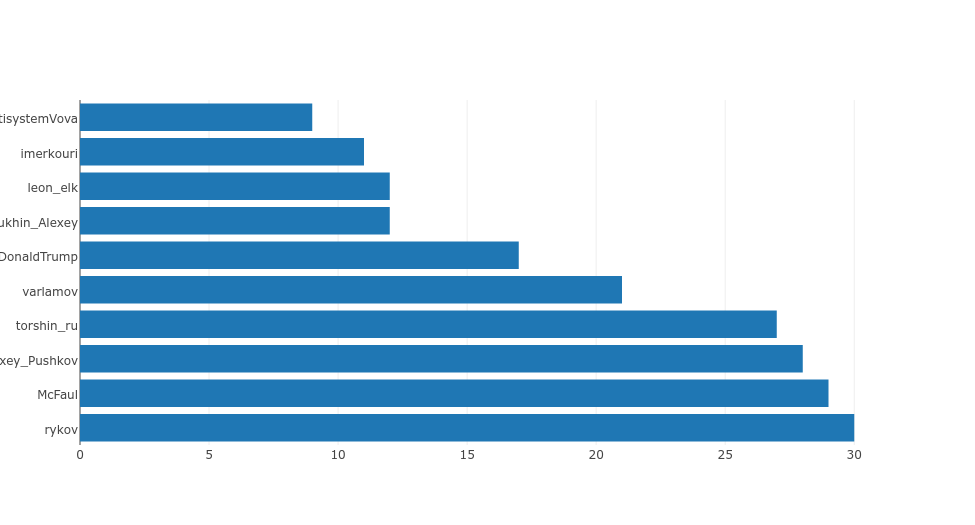

In [35]:
from IPython.display import Image
Image(filename='катасонова_10.png')

In [33]:
visual_top_10(baronova_text, 'ponny1')

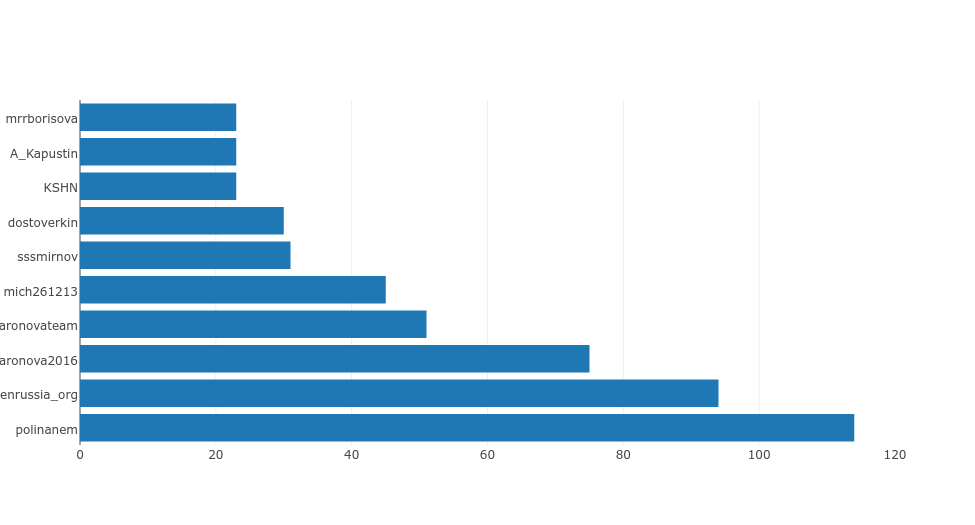

In [59]:
Image(filename='баронова_10.png')

In [34]:
visual_top_10(gudkov_text, 'gudkovd')

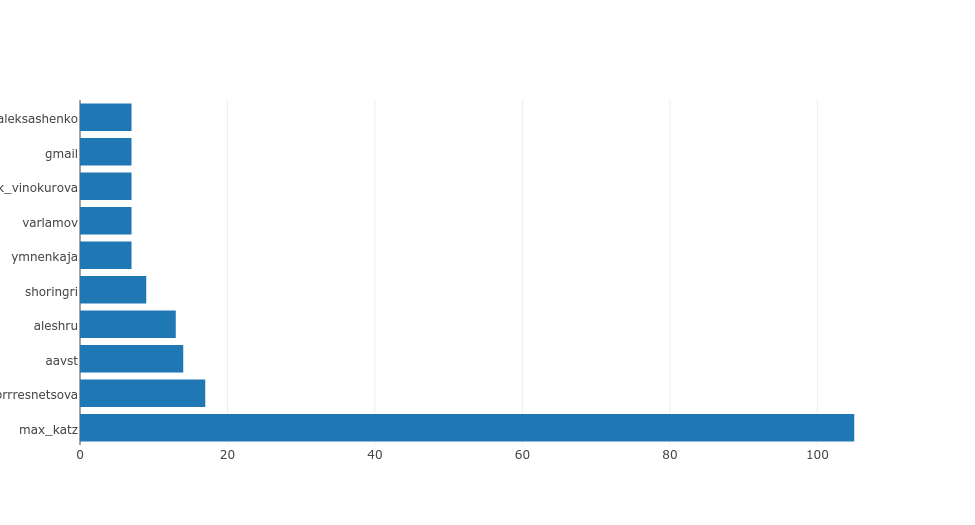

In [60]:
Image(filename='гудков_10.png')

In [36]:
len(baronova_text), len(gudkov_text), len(katasonova_text)

(1797, 2000, 1200)

### Посмотрим, когда чаще всего пишут данные кандидаты (день недели):

In [38]:
def top_day_of_week(person):
    person_day = []
    file = open(str(person) + '_twitter.txt', 'r')
    rawdata = file.read()
    for decoded in iterparse(rawdata):
        person_day.append(datetime.datetime.strptime(decoded['created_at'],
                                                         "%a %b %d %H:%M:%S +0000 %Y").strftime('%A'))
    weekday = []
    cont_day = []
    for k, v in Counter(person_day).most_common():
        weekday.append(k)
        cont_day.append(v)
    trace0 = go.Bar(
        x=weekday,
        y=cont_day,
        marker=dict(
            color=['rgb(32, 214, 93)', 'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
                   'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
                   'rgba(204,204,204,1)', 'rgba(222,45,38,0.8)']),
    )

    data = [trace0]
    layout = go.Layout(
        title='Days of the week',
    )

    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='color-bar')

In [39]:
top_day_of_week('gudkov')

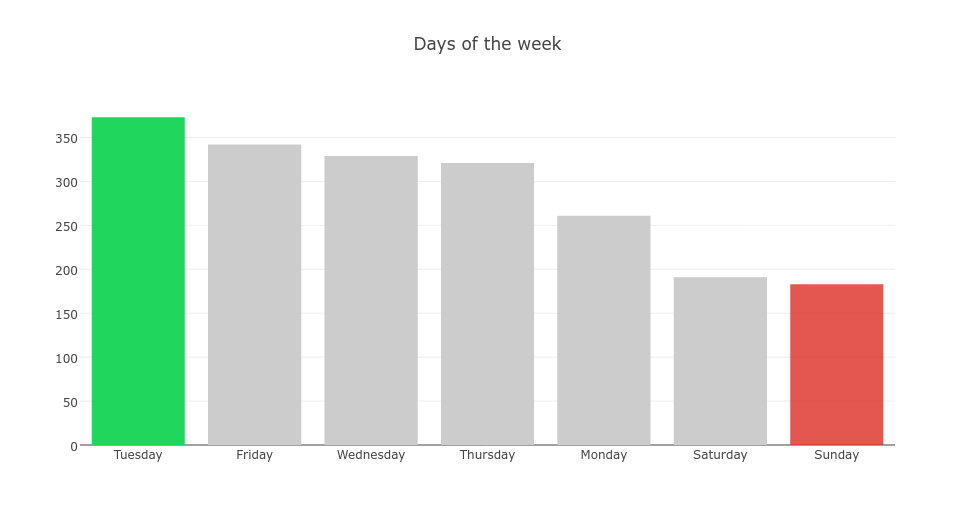

In [61]:
Image(filename='гудков.png')

In [40]:
top_day_of_week('baronova')

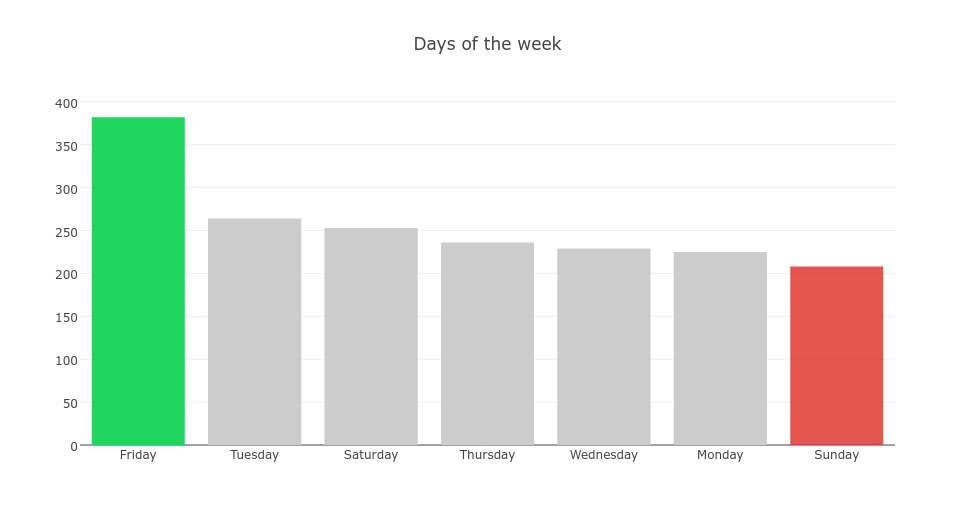

In [62]:
Image(filename='баронова.png')

In [41]:
top_day_of_week('katasonova')

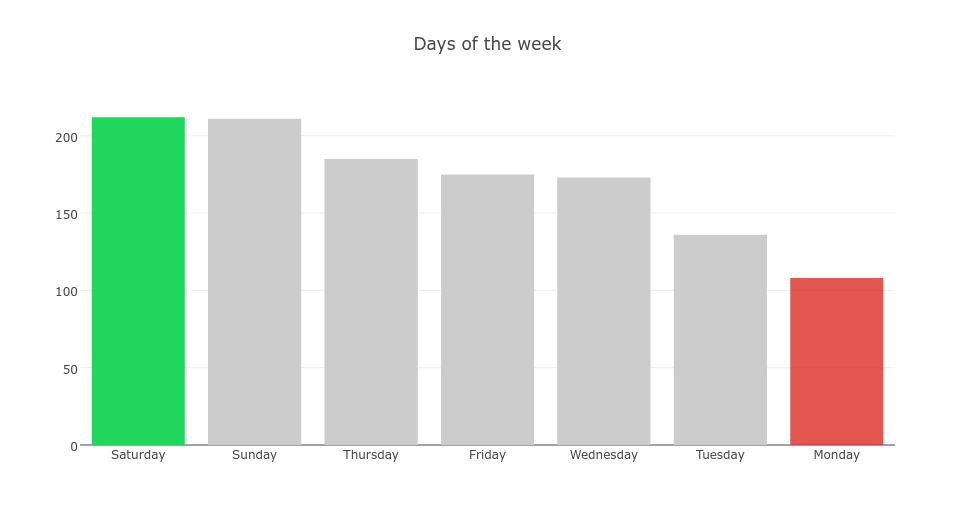

In [63]:
Image(filename='катасонова.png')

### А теперь точно также посмотрим время суток:

In [42]:
def top_time_of_day(person):
    person_day = []
    file = open(str(person) + '_twitter.txt', 'r')
    rawdata = file.read()
    for decoded in iterparse(rawdata):
        person_day.append(datetime.datetime.strptime(decoded['created_at'],
                                                         "%a %b %d %H:%M:%S +0000 %Y").strftime('%H'))
    weekday = []
    cont_day = []
    for k, v in Counter(person_day).most_common():
        weekday.append(k)
        cont_day.append(v)
#     Размечаю цвета
    color2 = []
    for i in range(len(weekday)):
        if i == 0:
            color2.append('rgb(32, 214, 93)')
        elif i == (len(weekday)-1):
            color2.append('rgba(222,45,38,0.8)')
        else:
            color2.append('rgba(204,204,204,1)')
    trace0 = go.Bar(
        x=weekday,
        y=cont_day,
        marker=dict(color = color2),
        )

    data = [trace0]
    layout = go.Layout(
        title='Times of Day',
    )

    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='color-bar')

In [43]:
top_time_of_day('baronova')

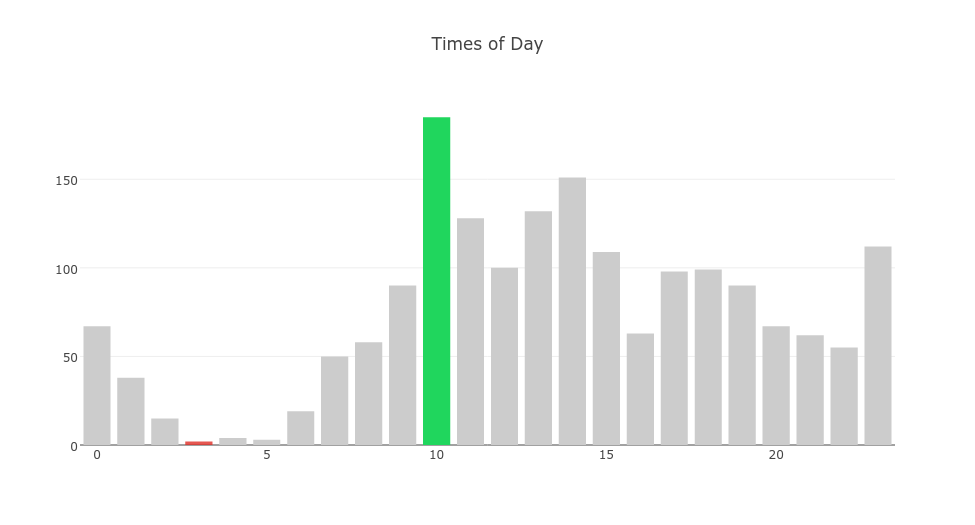

In [64]:
Image(filename='бар_день.png')

In [44]:
top_time_of_day('katasonova')

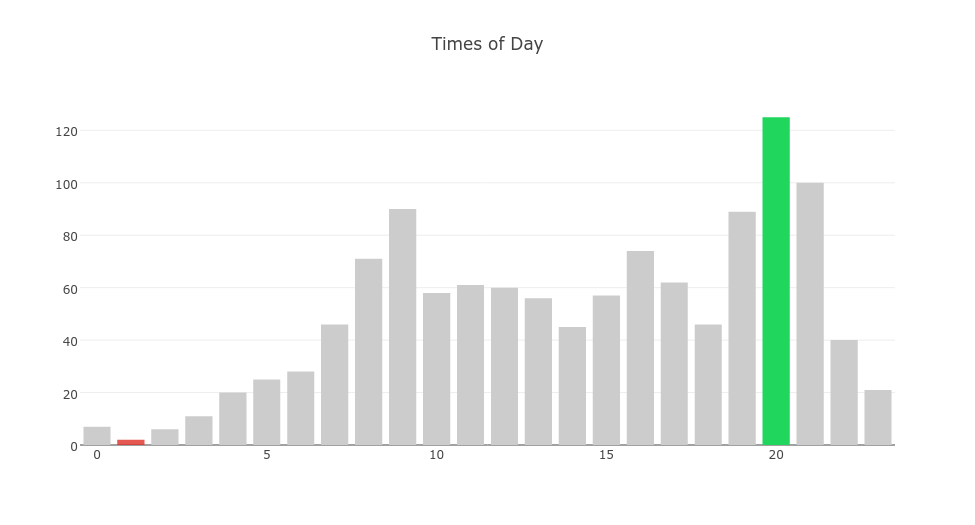

In [65]:
Image(filename='кат_день.png')

In [45]:
top_time_of_day('gudkov')

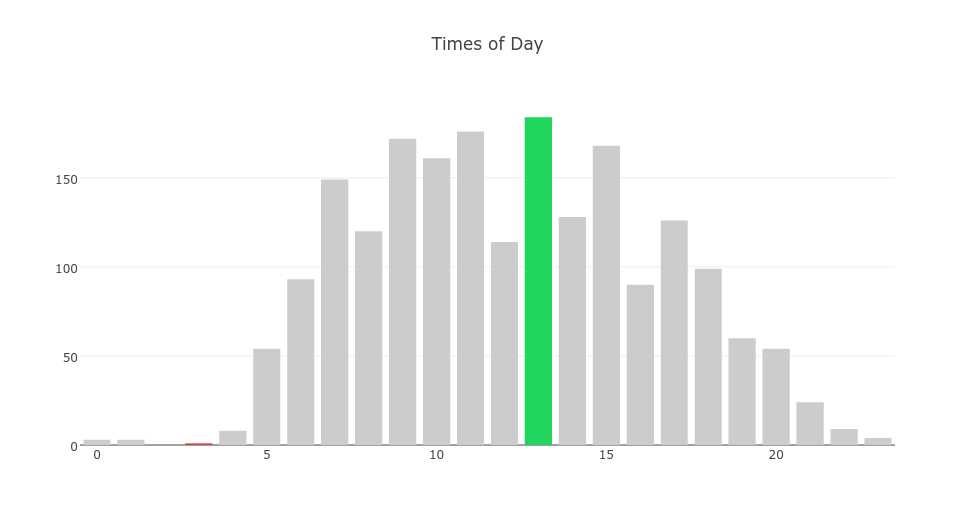

In [66]:
Image(filename='гуд_день.png')

### Количество твитов в месяц и среднее в день:

In [46]:
def mean_month(person):
    person_month = []
    p_for_mean = []
    file = open(str(person) + '_twitter.txt', 'r')
    rawdata = file.read()
    for decoded in iterparse(rawdata):
        person_month.append(datetime.datetime.strptime(decoded['created_at'],
                                                         "%a %b %d %H:%M:%S +0000 %Y").strftime('%b'))
        p_for_mean.append(datetime.datetime.strptime(decoded['created_at'],
                                                     "%a %b %d %H:%M:%S +0000 %Y").strftime('%b, %d'))
    month = []
    cont_day = []
    _m =[]
    _cnt = []
    for k, v in Counter(person_month).most_common():
        month.append(k)
        cont_day.append(v)
    for k1, v2 in Counter(p_for_mean).most_common():
        _m.append(k1)
        _cnt.append(v2)
    _cnt = np.mean(_cnt)
    _z0 = [_cnt] * len(month)
    
#     _dm = []
#     _month_mean = []
#     for j in range(len(_m)):
#         if set(set(_m[j]) & set(month)) == set():
#             _dm.append(_cnt[j])
#         else:
#             _month_mean.append(sum(_dm)/len(_dm))
    
    
    #     Размечаю цвета
    color2 = []
    for i in range(len(month)):
        if i == 0:
            color2.append('rgb(32, 214, 93)')
        elif i == (len(month)-1):
            color2.append('rgba(222,45,38,0.8)')
        else:
            color2.append('rgba(204,204,204,1)')
    trace0 = go.Bar(
        x=month,
        y=cont_day,
        marker=dict(
            color = color2),
        )
    trace1 = go.Scatter(
        x = month,
        y = _z0,
        marker = dict(color=['rgb(24, 24, 24)']),
        line = dict(dash='dot'))
    
#     trace2 = go.Scatter(
#         x = month,
#         y = _month_mean,
#         marker = dict(color=['rgb(24, 24, 24)']),
#         line=dict(color='rgba(223,247,0,1)'))
    
    data = [trace0, trace1
#             , trace2
           ]
    layout = go.Layout(
        title='Month',
    )

    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='color-bar')

In [48]:
mean_month('baronova')

In [50]:
mean_month('gudkov')

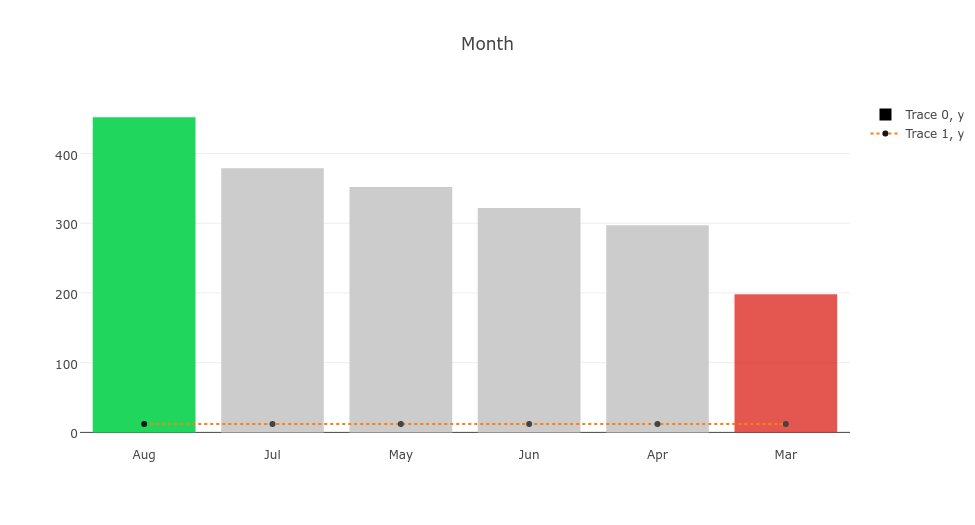

In [67]:
Image(filename='гуд_месяц.png')

In [57]:
mean_month('katasonova')

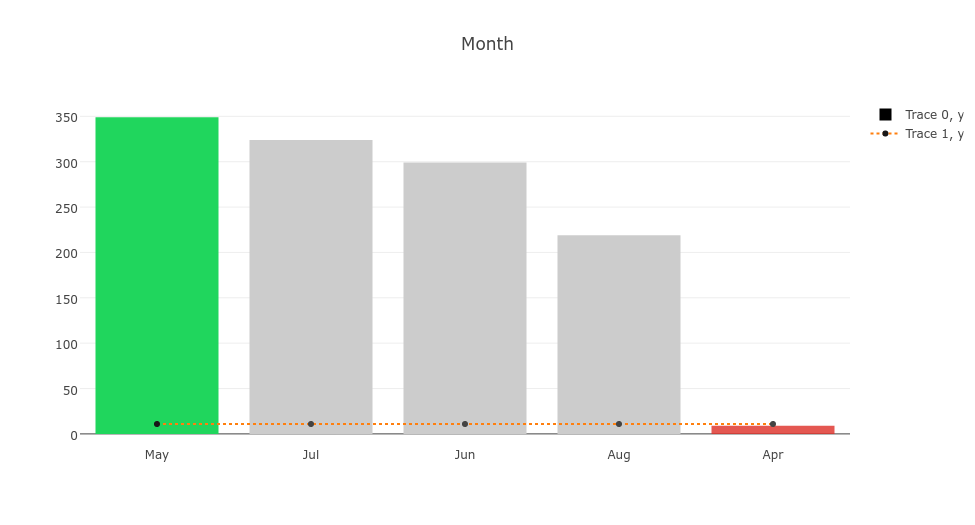

In [68]:
Image(filename='кат_месяц.png')

### Частота твитов-мнений:
Здесь я рассмотрел твиты из глобального поиска, где ключ == фамилии кандидата. Довольно интересные результаты получились, найдена даже одна бот-атака :)

In [51]:
_names = []
_val_names = []
def get_mentions(corpus):
    corpus_list = []
    file = open(str(corpus), 'r')
    rawdata = file.read()
    for decoded in iterparse(rawdata):
        corpus_list.append(prepare(decoded['text']))
    intcol = Counter(corpus_list)
    rnames  = intcol.most_common(11)[1:11]
    for k, v in intcol.most_common(11):
            _names.append(k)
            _val_names.append(v)
            print(k,v)
    print("===============================================================")        
    print(str("ALL TWEETS ABOUT PERSON: ") + str(len(corpus_list)))

In [52]:
get_mentions('bar_0709_data.json')

: оппа-оппа! на нтв очередное разоблачение «друзей ходорковского». на кадрах угадывается наша любименькая баронова.. 417
: завтра на нтв разоблачение «друзей ходорковского» и его "открытой россии". там и баронова есть... 39
: баронова про крым, зубова и другие вопросы, интересующие аудиторию эха. 27
: маркетолог - уровень бог. баронова, бери на вооружение! 23
: про "спойлерство": баронова в цао на 3 месяца раньше, собрала подписи, узнаваемость 26% против 12%.  привет всем. 23
: кандидат под n мария баронова: экономические свободы, личные свободы, жизнь и здоровье.. 12
: баронова оскверняет улицы москвы.. 11
: елена котова о том, почему марьям баронова – её кандидат. 9
: пиздец, какая клевая свежая баронова (особенно про попов)!!! скорее читайте! 9
: баронова постит фотографии с плакатами. один плакат - возле мечети. протестует против обрезания женщин. второй -... ://… 8
: мария баронова: ни одного бога нельзя защитить тюремными сроками для его критиков 7
ALL TWEETS ABOUT PERSON: 893


In [53]:
get_mentions('kat_0709_data.json')

: донецк. донецк сити проходит показ мод. за столиками депутаты, элита, и даже гости из москвы.
например катасонова 23
: мария катасонова: весь этот цирк 21
: катасонова мощно прыгнула на либералов..  ставлю в копию  20
: катасонова заставит зубова разлюбить гитлера 14
: когда выбирали нынешнего президента сша, маша катасонова стояла с плакатом "маккейн - война. обама - мир". 12
: катасонова народ в обиду не даст! голосуй за "родину", сука! 11
: катасонова своим вырезом прямо-таки напрашивается на новость в рпж, но я держусь. 6
мнения: мария катасонова: весь этот цирк 4
: катасонова идеальный последователь сталинизма и палачей нквд - доносики строчит
а зубов - абсолютно прав! разделяю! :… 4
: если за трампа агитирует катасонова, то значит в кремле страшно боятся хиллари клинтон 3
мария катасонова: б***ский цирк, а не русский «майдан». 3
ALL TWEETS ABOUT PERSON: 295


In [54]:
get_mentions('gud_0709_data.json')

: за 2015 год дмитрий гудков заработал почти 5 миллионов рублей, но деньги на избирательную компанию просит у народа. htt… 63
: молодой, перспективный политик дмитрий гудков, наверняка против протекционизма и семейственной клановости в политике. да. на… 57
: д.гудков и ж.немцова - в рубрике молодые гении, добившиеся всего сами, или как придти к успеху без помощи родителей. :/… 32
: дмитрий гудков  в немцоваинтервью: яровая предательски поступила. подробности - 16
: геннадий гудков, это... 14
: нормально так димасик гудков отстроился 12
: дмитрий гудков в немцоваинтервью: ни о каких честных выборах говорить не приходится 
еще:  :/… 11
: бывший депутат гд - г.гудков, обращается к электорату с призывом голосовать за действующего депутата гд - д.гудкова :/… 10
геннадий гудков: банкет «единой россии» за бюджетный счёт 8
: а вот подписи каких единороссов брал кандидат гена гудков, шедший под лозунгом борьбы с коррупцией  5
: лев гудков: список «иностранных агентов» будет только расти 5
ALL T

## Выводы:

Какие выводы можно сделать? 

Например, самый очевидный -- что Мария Катасонова пишет в твиттер не только политическую агитацию, но и какие-то личные сообщения. А Дмитрий Гудков, наоборот, к августу стал писать больше, чем до этого, притом, что его твиты даже не делятся на темы; в большинстве своем составляют политическую агитацию. Мария Баронова, аналогично раскручивает свою кандидатуру -- это можно заметить и по тем твиттер-аккаунтам, которые она упоминает в своих твитах (весь топ-4 занимают твиттеры, как-либо связанные с ней). У Гудкова и Бароновой топ-1 по упоминаниям их главы предвыборных штабов. По активности в дни недели интересная закономерность -- у Гудкова и Бароновой есть дети, очевидно, что свои выходные они посвящают им. У молодой Марии Катасоновой детей нет, вероятно поэтому чаще всего в твиттер она пишет в выходные.

Вообще, подводя итог, можно сделать много выводов из поведения кандидатов, а также из их манеры/стиля письма.

Работа над этим ведется.